# HW3 Q2

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import os

In [0]:
tf.__version__

'1.15.0'

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
len(data.train.images) # Train image count

55000

In [0]:
len(data.test.images) # Test image count

10000

### Data dimensions

In [0]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Placeholder variables

In [0]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
Z = tf.placeholder(tf.float32, [None, 100])
#x_1 = tf.placeholder(tf.float32, [None, img_size_flat])

In [0]:
output_true = tf.placeholder(tf.float32, [None, img_size_flat])
# = tf.placeholder(tf.float32, [None, img_size_flat])

In [0]:
#y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

d_vars = [D_W1, D_W2, D_b1, D_b2]


G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

g_vars = [G_W1, G_W2, G_b1, G_b2]

### Model

In [0]:


def discriminator_network(discriminator_input):
    D_h1 = tf.nn.relu(tf.matmul(discriminator_input, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return (D_prob+1e-3), D_logit

def generator_network(generator_input):
    G_h1 = tf.nn.relu(tf.matmul(generator_input, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

generated_image = generator_network(Z)

prediction_generated, D_logit_fake = discriminator_network(generated_image)
prediction_real, D_logit_real = discriminator_network(x)

### Cost-function to be optimized

In [0]:
#d_loss = -tf.reduce_mean(tf.log(prediction_real) + tf.log(1. - prediction_generated))
#g_loss = -tf.reduce_mean(tf.log(prediction_generated))
# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
d_loss = D_loss_real + D_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Optimization method

In [0]:
learning_rate = 0.0001
d_optimizer = tf.train.AdamOptimizer(learning_rate =learning_rate).minimize(d_loss, var_list=d_vars)
g_optimizer = tf.train.AdamOptimizer(learning_rate =learning_rate).minimize(g_loss, var_list=g_vars)


## TensorFlow Run

In [0]:
session = tf.Session()

In [0]:
session.run(tf.global_variables_initializer())

In [0]:
def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])

TRAIN FUNCTION

In [0]:
def train(mb_size=512, gen_input_dim = 100):
    d_loss_array = []
    g_loss_array = []
    for it in range(int(len(data.train.images) / mb_size)):
        x_batch, _ = data.train.next_batch(mb_size)

        _, d_loss_curr = session.run([d_optimizer, d_loss],
                                  feed_dict={x: x_batch, Z: sample_Z(mb_size, gen_input_dim)})
        #if it %3 == 0:
        for a in range(3):  #generator works 3 times of disc. does.
          _, g_loss_curr = session.run([g_optimizer, g_loss],
                                      feed_dict={Z: sample_Z(mb_size, gen_input_dim)})
          g_loss_array.append(g_loss_curr)
        d_loss_array.append(d_loss_curr)
    return np.mean(d_loss_array), np.mean(g_loss_array)

VISUALIZE

In [0]:

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


TRAIN THE MODEL

Generator Loss at epoch 0 is 2.9582622
Discriminator Loss at epoch 0 is 0.31794703
SAMPLES @ EPOCH :  0
Generator Loss at epoch 1 is 1.9210377
Discriminator Loss at epoch 1 is 0.62165105
Generator Loss at epoch 2 is 1.6109834
Discriminator Loss at epoch 2 is 0.66148037
Generator Loss at epoch 3 is 1.5309372
Discriminator Loss at epoch 3 is 0.6020703
Generator Loss at epoch 4 is 1.2189279
Discriminator Loss at epoch 4 is 0.6949601
Generator Loss at epoch 5 is 0.9470167
Discriminator Loss at epoch 5 is 0.8165755
Generator Loss at epoch 6 is 0.8766652
Discriminator Loss at epoch 6 is 0.8584912
Generator Loss at epoch 7 is 0.9840339
Discriminator Loss at epoch 7 is 0.7564626
Generator Loss at epoch 8 is 1.0691987
Discriminator Loss at epoch 8 is 0.70357436
Generator Loss at epoch 9 is 1.1130886
Discriminator Loss at epoch 9 is 0.692608
Generator Loss at epoch 10 is 1.2236807
Discriminator Loss at epoch 10 is 0.68549937
SAMPLES @ EPOCH :  10
Generator Loss at epoch 11 is 1.1066512
Discrimin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Generator Loss at epoch 201 is 1.391162
Discriminator Loss at epoch 201 is 0.92185855
Generator Loss at epoch 202 is 1.4150413
Discriminator Loss at epoch 202 is 0.9095251
Generator Loss at epoch 203 is 1.4094962
Discriminator Loss at epoch 203 is 0.90081483
Generator Loss at epoch 204 is 1.4020661
Discriminator Loss at epoch 204 is 0.90674853
Generator Loss at epoch 205 is 1.4108666
Discriminator Loss at epoch 205 is 0.8988829
Generator Loss at epoch 206 is 1.4059296
Discriminator Loss at epoch 206 is 0.900795
Generator Loss at epoch 207 is 1.4118631
Discriminator Loss at epoch 207 is 0.8926417
Generator Loss at epoch 208 is 1.417498
Discriminator Loss at epoch 208 is 0.8890589
Generator Loss at epoch 209 is 1.4261448
Discriminator Loss at epoch 209 is 0.8972
Generator Loss at epoch 210 is 1.4271237
Discriminator Loss at epoch 210 is 0.9029567
SAMPLES @ EPOCH :  210
Generator Loss at epoch 211 is 1.4200273
Discriminator Loss at epoch 211 is 0.9068843
Generator Loss at epoch 212 is 1.4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


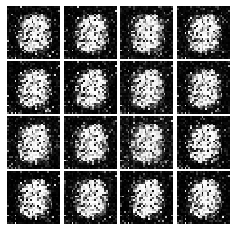

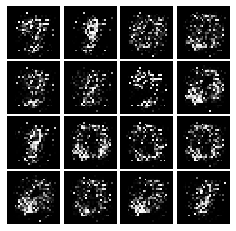

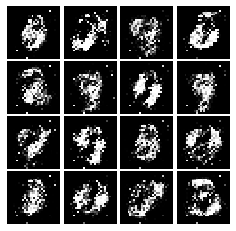

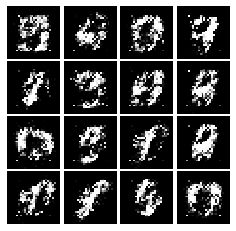

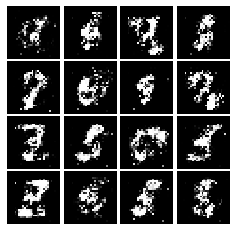

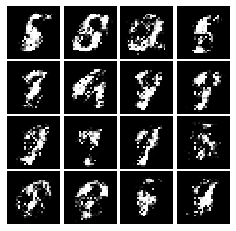

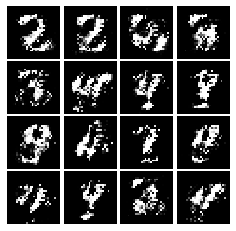

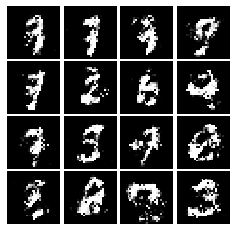

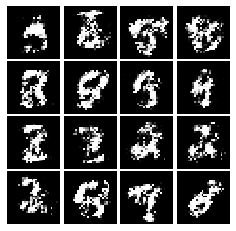

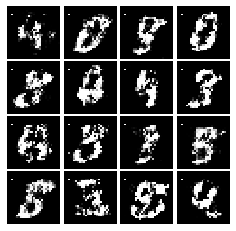

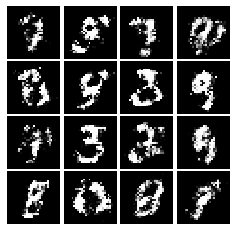

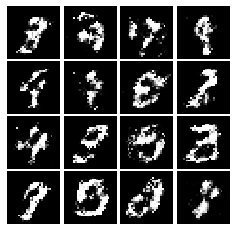

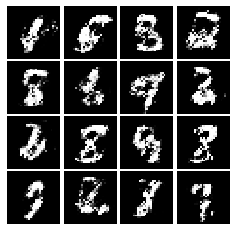

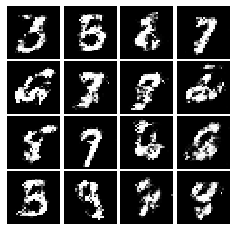

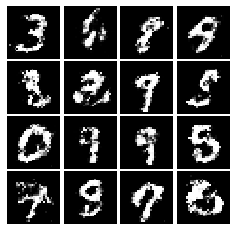

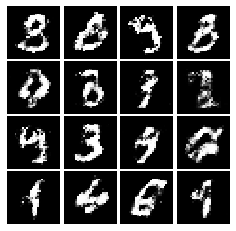

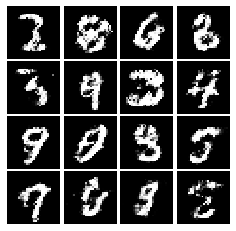

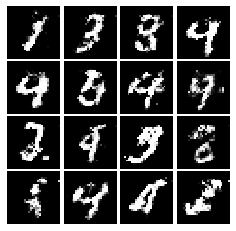

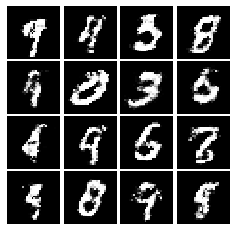

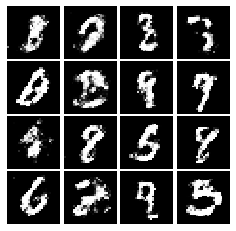

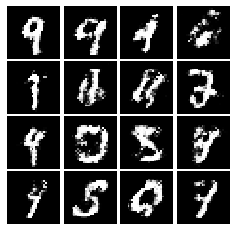

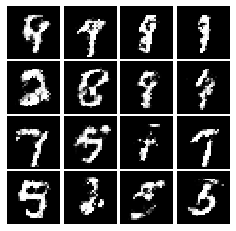

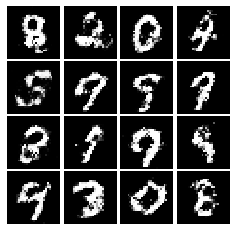

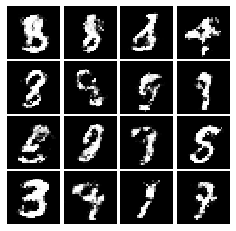

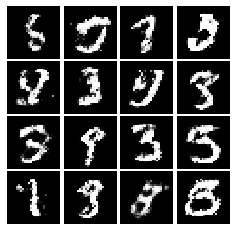

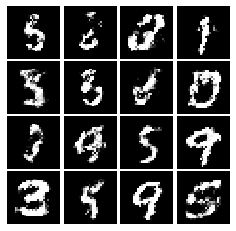

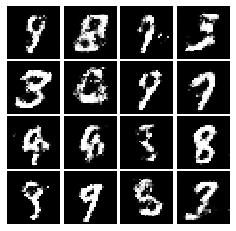

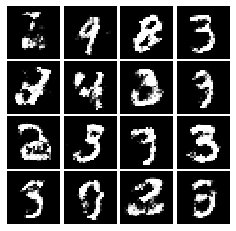

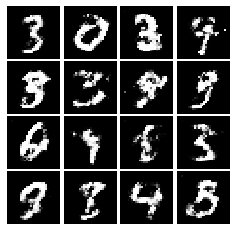

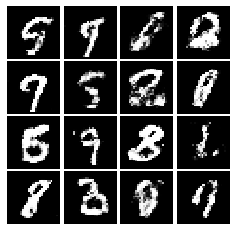

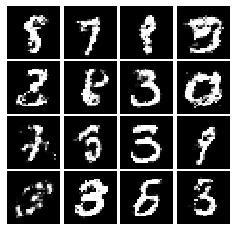

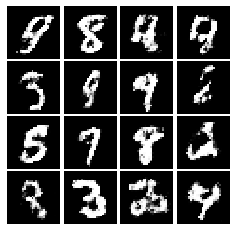

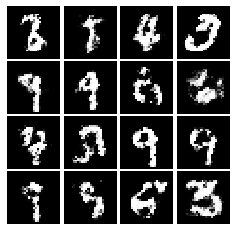

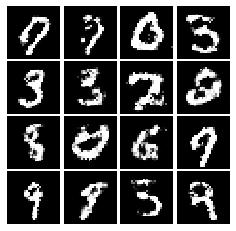

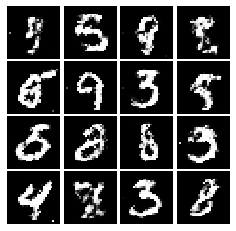

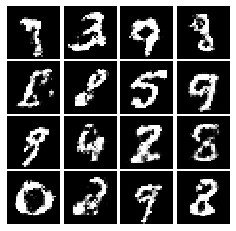

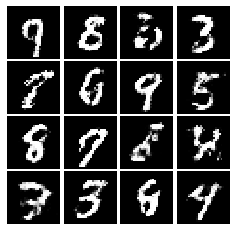

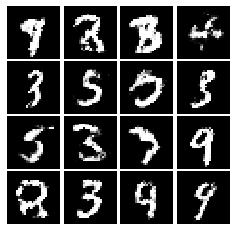

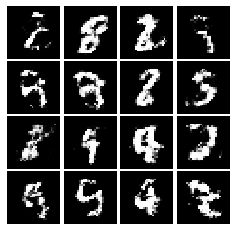

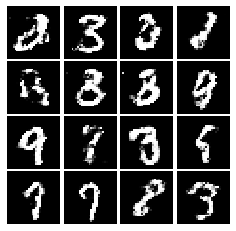

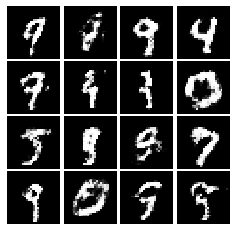

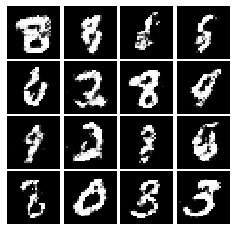

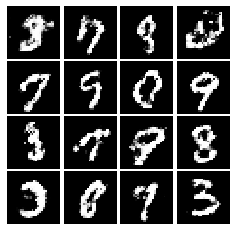

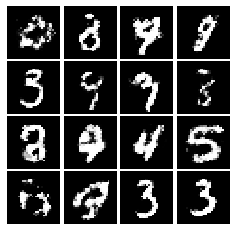

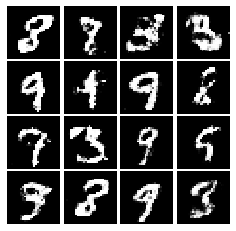

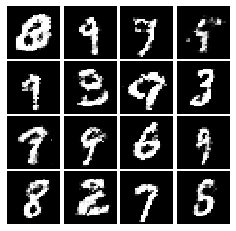

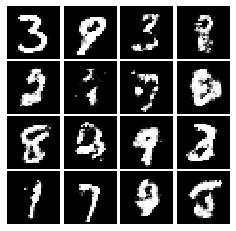

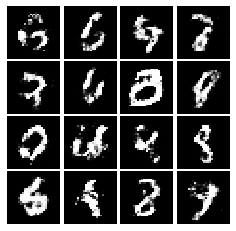

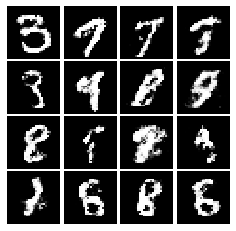

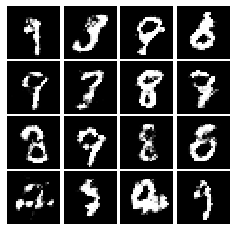

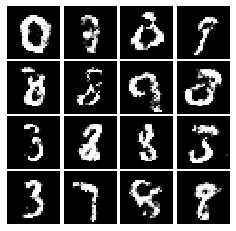

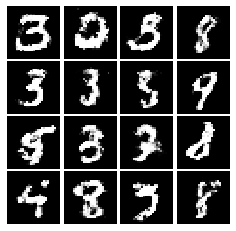

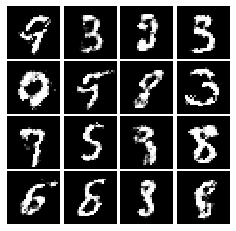

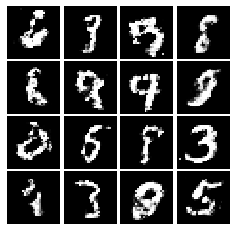

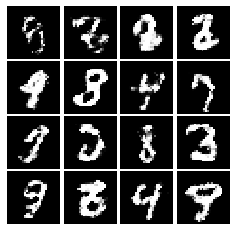

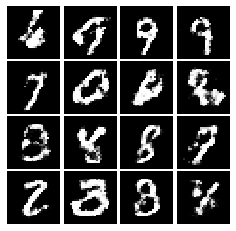

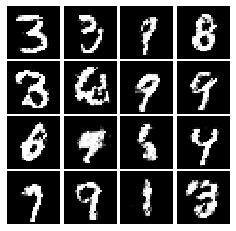

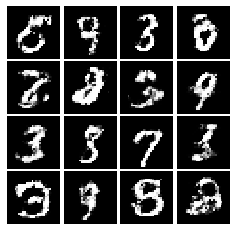

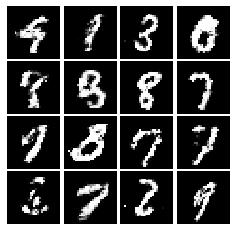

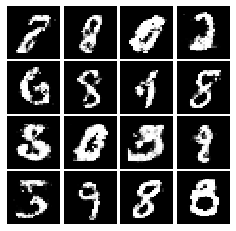

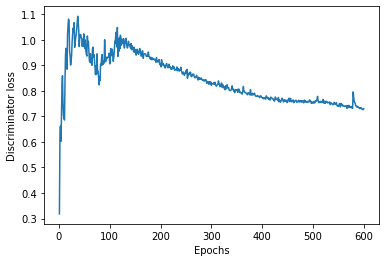

Final Generator Loss is :  1.8991532


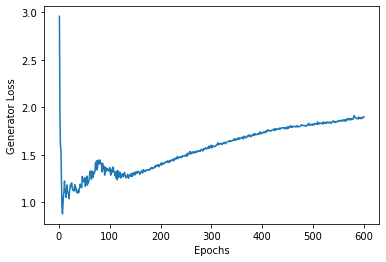

In [0]:

disc_loss_array = []
gen_loss_array = []
epochs = 600
for k in range(epochs) :
    disc_loss, gen_loss = train();
    disc_loss_array.append(disc_loss)
    gen_loss_array.append(gen_loss)
    print("Generator Loss at epoch",k,"is",gen_loss)
    print("Discriminator Loss at epoch",k,"is",disc_loss)
    if k%10 == 0:
      print("SAMPLES @ EPOCH : ",k)
      samples = session.run(generated_image, feed_dict={Z: sample_Z(16,100)})    
      fig = plot(samples)
  
a = np.linspace (1,epochs,epochs)

plt.figure()
plt.plot(a,disc_loss_array)
plt.xlabel("Epochs")
plt.ylabel("Discriminator loss")
print("Final Discriminator Loss is : ", disc_loss_array[-1])
plt.show()

plt.figure()
plt.plot(a,gen_loss_array)
plt.xlabel("Epochs")
plt.ylabel("Generator Loss")
print("Final Generator Loss is : ", gen_loss_array[-1])
plt.show()
  

In [0]:
session.close()

## References

[1] https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

[2]  https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_tensorflow.py

[3]  https://medium.com/@fabulousjeong/gan-with-tensorflow-basics-of-generative-adversarial-networks-d71bb9a4cae2